In [62]:
from stg import STG
#from lasso  import LogisticRegression
import numpy as np
import pandas as pd
import scipy.stats # for creating a simple dataset 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from dataset import create_twomoon_dataset
import torch
from torch.utils.data import DataLoader
from sklearn.feature_selection import RFE,SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer, make_classification,load_digits
import warnings
warnings.filterwarnings('ignore')


## Visualize the Data

In [78]:
n_size = 1000 
p_size = 20   
X_data, y_data=create_twomoon_dataset(n_size,p_size)
X_data[y_data == 1, 1] -= 0.85 
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

(1000,)
(1000, 20)


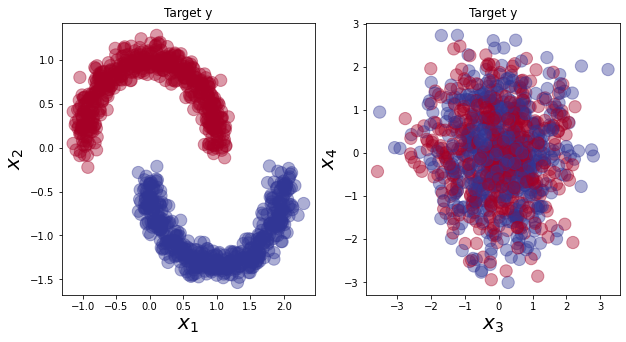

In [79]:
f,ax = plt.subplots(1,2,figsize=(10,5))
        

ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:,2], y=X_data[:,3], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].set_xlabel('$x_3$',fontsize=20)
ax[1].set_ylabel('$x_4$',fontsize=20)
ax[1].set_title('Target y')
plt.tick_params(labelsize=10)

## Filter Method

In [80]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
chi2_selector = SelectKBest(chi2, k=2)
X_kbest = chi2_selector.fit_transform(X_scaled, y_train)
selected_features_bool = chi2_selector.get_support()
print("The Selected Features:",selected_features_bool)
X_test_kbest = chi2_selector.transform(X_test_scaled) 
selected_features = chi2_selector.get_support(indices=True)
logistic_regression_model = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
logistic_regression_model.fit(X_kbest, y_train)
y_pred_chi2 = logistic_regression_model.predict(X_test_kbest)
chi2_acc=accuracy_score(y_test,y_pred_chi2)
print("accuracy:",chi2_acc)

The Selected Features: [ True  True False False False False False False False False False False
 False False False False False False False False]
accuracy: 1.0


## Wrapper Method

In [81]:
logistic_reg = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
rfe_model = RFE(estimator=logistic_reg, n_features_to_select=2, step=1)
rfe_model.fit(X_train, y_train)
selected_features_bool = rfe_model.get_support()
print("The Selected Features:",selected_features_bool)
y_pred_rfe = rfe_model.predict(X_test)
chi2_acc=accuracy_score(y_test,y_pred_chi2)
print("accuracy:",chi2_acc)

The Selected Features: [ True  True False False False False False False False False False False
 False False False False False False False False]
accuracy: 1.0


## Embedded Method

In [82]:
min_log = np.log10(0.005)
max_log = np.log10(2)
num_values = 20
reg_coeff_values = np.logspace(min_log, max_log, num=num_values)
select_features_list=[]
val_acc_list=[]
coeffs=[]
select_feature=0
test_acc_list=[]
for reg_coeff in reg_coeff_values: 
   # reg_coeff_values.append(reg_coeff)
    # Create a Logistic Regression model with L1 penalty (Lasso) 
    model = LogisticRegression(penalty='l1', C=1/reg_coeff, solver='saga',max_iter=300, random_state=42)
    model.fit(X_train, y_train)
    select_feature=np.sum(model.coef_!= 0)
    select_features_list.append(select_feature)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    val_acc_list.append(accuracy)
    coeffs.append(model.coef_)
#reg_coeff_values_array = np.array(reg_coeff_values)
select_features_array = np.array(select_features_list)
coeffs_array = np.array(coeffs)
coeffs_flattened = coeffs_array.squeeze()


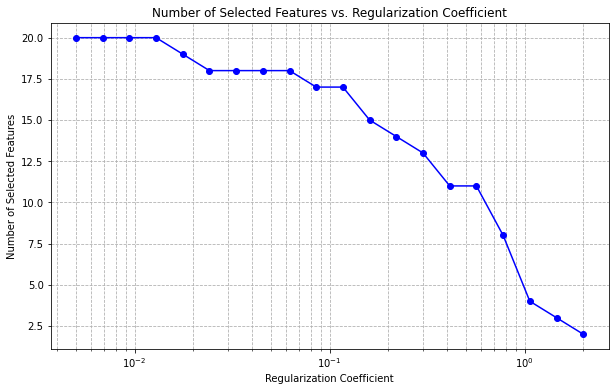

In [83]:
# Plotting Number of Selected Features vs. Regularization Coefficient
plt.figure(figsize=(10,6))
plt.plot(reg_coeff_values, select_features_array, '-o', color='blue')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Number of Selected Features')
plt.title('Number of Selected Features vs. Regularization Coefficient')
plt.xscale('log') 
plt.grid(True, which="both", ls="--")
plt.show()

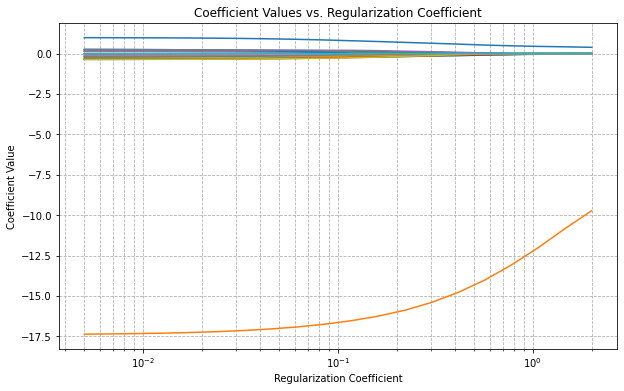

In [84]:
plt.figure(figsize=(10, 6))
# Plot each feature's coefficient change
for i in range(coeffs_flattened.shape[1]):  # Iterate over each feature
    plt.plot(reg_coeff_values, coeffs_flattened[:, i], label=f'Feature {i+1}')

plt.xlabel('Regularization Coefficient')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Values vs. Regularization Coefficient')
plt.xscale('log')
plt.grid(True, which="both", ls="--")


In [151]:
def clean_feature_selection_data(reg_coeff_values, select_features_list, test_acc_list):
    # Create a DataFrame from your lists
    data = {
        'Reg Coeff': reg_coeff_values,
        'Selected Features': select_features_list,
        'Test Accuracy': test_acc_list
    }
    df = pd.DataFrame(data)
    
    # Ensure the data is sorted by regularization coefficient
    #df.sort_values('Reg Coeff', ascending=True, inplace=True)

    # Keep track of the last valid number of selected features
    last_valid = float('inf')

    # Iterate backwards and discard rows where the feature count increases
    for index, row in df.iterrows():
        if row['Selected Features'] <= last_valid:
            last_valid = row['Selected Features']
        else:
            df.drop(index, inplace=True)

    # Sort by regularization coefficient after cleaning
    df_sorted = df.sort_values(by=['Selected Features', 'Test Accuracy'], ascending=[True, False])
    df_unique = df_sorted.drop_duplicates(subset=['Selected Features'], keep='first')
    df_unique = df_unique.sort_values(by='Reg Coeff')
    unique_reg_coeff_values = df_unique['Reg Coeff'].tolist()
    unique_select_features_list = df_unique['Selected Features'].tolist()
    unique_test_acc_list = df_unique['Test Accuracy'].tolist()
    
    return unique_reg_coeff_values,unique_select_features_list,unique_test_acc_list


In [86]:
def experiment(x,y,min_features=2,max_log_coef=2,max_iter=300):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    min_log = np.log10(0.0001)
    max_log = np.log10(max_log_coef)
    num_values = round(x.shape[1]*1.5)
    reg_coeff_values = np.logspace(min_log, max_log, num=num_values)
    select_features_list=[]
    select_feature=0
    lasso_acc=[]
    for reg_coeff in reg_coeff_values:  
        # Create a Logistic Regression model with L1 penalty (Lasso) 
        model = LogisticRegression(penalty='l1', C=1/reg_coeff, solver='saga',max_iter=max_iter, random_state=42)
        model.fit(X_train, y_train)
        select_feature=np.sum(model.coef_!= 0)
        select_features_list.append(select_feature)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        lasso_acc.append(accuracy)
    #reg_coeff_values_array = np.array(reg_coeff_values)
    select_features_lasso = np.array(select_features_list)

    chi2_acc=[]
    rfe_acc=[]
    min_num_features=min(select_features_lasso)
    max_num_features=max(select_features_lasso)

    num_features_chi2_rfe = range(min_features,max_num_features+1)  # For Chi-Squared and RFE
    
    for i in num_features_chi2_rfe:
        chi2_selector = SelectKBest(chi2, k=i)
        X_kbest = chi2_selector.fit_transform(X_scaled, y_train)
        X_test_kbest = chi2_selector.transform(X_test_scaled) 
        selected_features = chi2_selector.get_support(indices=True)
        logistic_regression_model = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
        logistic_regression_model.fit(X_kbest, y_train)
        y_pred_chi2 = logistic_regression_model.predict(X_test_kbest)

        logistic_reg = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
        rfe_model = RFE(estimator=logistic_reg, n_features_to_select=i, step=1)
        rfe_model.fit(X_train, y_train)
        y_pred_rfe = rfe_model.predict(X_test)

        chi2_acc.append(accuracy_score(y_test, y_pred_chi2))
        rfe_acc.append(accuracy_score(y_test, y_pred_rfe))

    return chi2_acc,rfe_acc,lasso_acc,num_features_chi2_rfe,select_features_lasso

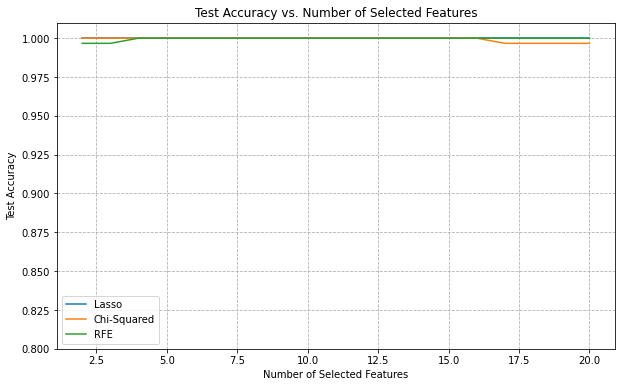

In [87]:
chi2_acc, rfe_acc, lasso_acc, num_features_chi2_rfe, select_features_lasso = experiment(X_data,y_data)
plt.figure(figsize=(10,6))
plt.plot(select_features_lasso, lasso_acc,label='Lasso')
plt.plot(num_features_chi2_rfe, chi2_acc, label='Chi-Squared')
plt.plot(num_features_chi2_rfe, rfe_acc, label='RFE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Selected Features')
plt.grid(True,ls="--")
plt.ylim(0.8,1.01)
plt.legend()
plt.show()

## Feature Selection Techniques Evaluation on Multiple Dataset

In [88]:
# Synthetic Dataset- linear Two Moons
n_size = 1000 
p_size = 60   
X_moon_lin, y_moon_lin=create_twomoon_dataset(n_size,p_size)
X_moon_lin[y_moon_lin == 1, 1] -= 0.84 

# Breast Cancer Wisconsin Dataset
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)

# Digits Dataset
X_digits, y_digits = load_digits(return_X_y=True)
binary_mask = (y_digits == 1) | (y_digits == 4)
X_digits = X_digits[binary_mask]
y_digits = y_digits[binary_mask]


# Synthetic Dataset- non-linear Two Moons  
X_moon, y_moon=create_twomoon_dataset(n_size,p_size)

datasets = {
    'linear Two Moons': (X_moon_lin, y_moon_lin),
    'Breast Cancer': (X_cancer, y_cancer),
    'Digits': (X_digits, y_digits),
    'non-linear Two Moons':(X_moon,y_moon)
}


(1000,)
(1000, 60)
(1000,)
(1000, 60)


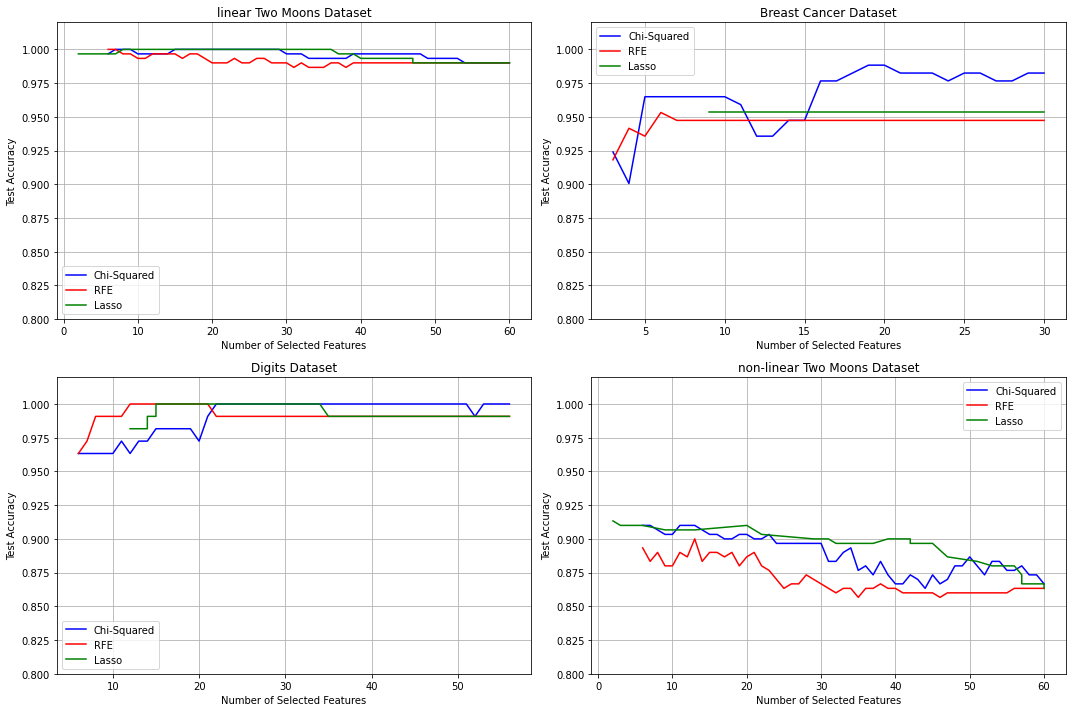

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten() 

for i, (name, (X, y)) in enumerate(datasets.items()):
    chi2_acc, rfe_acc, lasso_acc, num_features_chi2_rfe, select_features_lasso = experiment(X,y,round(0.1*X.shape[1]),20,max_iter=500)
    
    
    axes[i].plot(num_features_chi2_rfe, chi2_acc, label='Chi-Squared', color='blue')
    axes[i].plot(num_features_chi2_rfe, rfe_acc, label='RFE', color='red')
    axes[i].plot(select_features_lasso, lasso_acc, label='Lasso', color='green')  # Assuming select_features_lasso and lasso_acc are aligned

    axes[i].set_title(f'{name} Dataset') 
    axes[i].set_xlabel('Number of Selected Features')
    axes[i].set_ylabel('Test Accuracy')
    axes[i].set_ylim(0.8,1.02)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Feature Selection Using Stochastic Gates

In [126]:
n_size = 1000 #Number of samples
p_size = 20   #Number of features
X_data, y_data=create_twomoon_dataset(n_size,p_size,0.1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

(1000,)
(1000, 20)


In [127]:
feature_selection = True
model = STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.5, random_state=42, device='cpu') 

In [128]:
model.fit(X_train, y_train, nr_epochs=6000, valid_X=X_valid, valid_y=y_valid, print_interval=1000)

Epoch: 1000: loss=0.373258 valid_loss=0.233338
Epoch: 2000: loss=0.091443 valid_loss=0.034891
Epoch: 3000: loss=0.070979 valid_loss=0.023076
Epoch: 4000: loss=0.066878 valid_loss=0.020083
Epoch: 5000: loss=0.065007 valid_loss=0.019381
Epoch: 6000: loss=0.064450 valid_loss=0.018187


In [129]:
model.get_gates(mode='prob')

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [130]:
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


In [173]:
min_log = np.log10(0.05)
max_log = np.log10(0.5)
num_values = 40  

# Generate the regularization strength values
reg_coeff_values = np.logspace(min_log, max_log, num=num_values)
select_features_list=[]
test_acc_list=[]
gates_prob=[]
gates_mu=[]
feature_selection = True
select_feature=0
for reg_coeff in reg_coeff_values:
    model = STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
        optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=reg_coeff, random_state=1, device='cpu')
    print(f"Reg_coef= {reg_coeff:.4f}")
    model.fit(X_train, y_train, nr_epochs=5000, valid_X=X_valid, valid_y=y_valid, print_interval=5000)
    select_feature=sum(model.get_gates(mode='prob') > 0)
    y_pred=model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    select_features_list.append(select_feature)
    test_acc_list.append(accuracy)
    gates_mu.append(model.get_gates(mode='raw'))
    gates_prob.append(model.get_gates(mode='prob'))

Reg_coef= 0.0500
Epoch: 5000: loss=0.049452 valid_loss=0.512702
Reg_coef= 0.0530
Epoch: 5000: loss=0.059732 valid_loss=0.459707
Reg_coef= 0.0563
Epoch: 5000: loss=0.057611 valid_loss=0.411487
Reg_coef= 0.0597
Epoch: 5000: loss=0.054885 valid_loss=0.161733
Reg_coef= 0.0633
Epoch: 5000: loss=0.062533 valid_loss=0.778948
Reg_coef= 0.0672
Epoch: 5000: loss=0.066764 valid_loss=0.660944
Reg_coef= 0.0713
Epoch: 5000: loss=0.063023 valid_loss=0.072334
Reg_coef= 0.0756
Epoch: 5000: loss=0.073589 valid_loss=0.570081
Reg_coef= 0.0802
Epoch: 5000: loss=0.073668 valid_loss=0.607796
Reg_coef= 0.0851
Epoch: 5000: loss=0.066973 valid_loss=0.160723
Reg_coef= 0.0902
Epoch: 5000: loss=0.070110 valid_loss=0.104365
Reg_coef= 0.0957
Epoch: 5000: loss=0.082624 valid_loss=0.415723
Reg_coef= 0.1015
Epoch: 5000: loss=0.072647 valid_loss=0.082854
Reg_coef= 0.1077
Epoch: 5000: loss=0.086388 valid_loss=0.281661
Reg_coef= 0.1143
Epoch: 5000: loss=0.081949 valid_loss=0.458576
Reg_coef= 0.1212
Epoch: 5000: loss=0.066

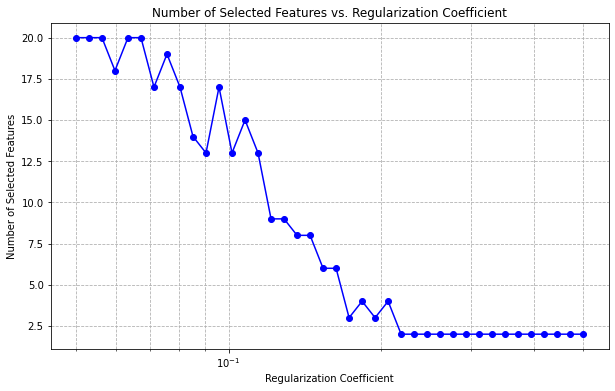

In [174]:
# Plotting Number of Selected Features vs. Regularization Coefficient
plt.figure(figsize=(10,6))
plt.plot(reg_coeff_values, select_features_list, '-o', color='blue')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Number of Selected Features')
plt.title('Number of Selected Features vs. Regularization Coefficient')
plt.xscale('log') # Since regularization coefficients can vary over orders of magnitude
plt.grid(True, which="both", ls="--")
plt.show()

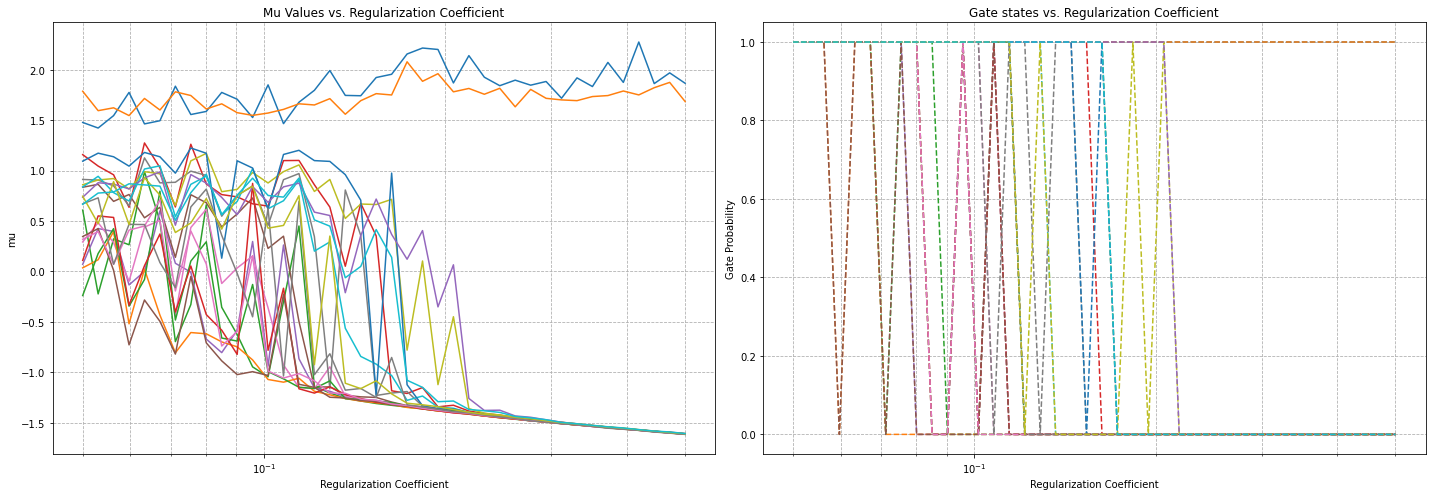

In [177]:
# mu_array = np.array(gates_mu)

# plt.figure(figsize=(10, 6))

# # Plot the change in importance for each feature across regularization strengths
# # Assuming each row in gates_prob_array corresponds to a set of feature importances for a given reg_coeff
# for i in range(mu_array.shape[1]):  # Iterate over each feature
#     plt.plot(reg_coeff_values, mu_array[:, i], label=f'Feature {i+1}')

# plt.xlabel('Regularization Coefficient')
# plt.ylabel('mu')
# plt.title('mu vs. Regularization Coefficient')
# plt.xscale('log')
# plt.grid(True, which="both", ls="--")

mu_array = np.array(gates_mu)
prob_array = np.array(gates_prob)

# Setup the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))  # 1 row, 2 columns

# Plotting 'mu' values on the first subplot
for i in range(mu_array.shape[1]):
    ax1.plot(reg_coeff_values, mu_array[:, i], label=f'Mu Feature {i+1}')
ax1.set_title('Mu Values vs. Regularization Coefficient')
ax1.set_xlabel('Regularization Coefficient')
ax1.set_ylabel('mu')
ax1.set_xscale('log')
ax1.grid(True, which="both", ls="--")

# Plotting gate probabilities on the second subplot
for i in range(prob_array.shape[1]):
    ax2.plot(reg_coeff_values, prob_array[:, i]>0, '--', label=f'Prob Feature {i+1}')
ax2.set_title('Gate states vs. Regularization Coefficient')
ax2.set_xlabel('Regularization Coefficient')
ax2.set_ylabel('Gate Probability')
ax2.set_xscale('log')
ax2.grid(True, which="both", ls="--")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

plt.show()

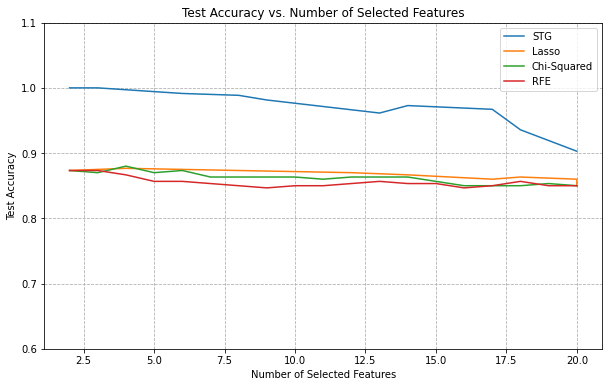

In [178]:
chi2_acc, rfe_acc, lasso_acc, num_features_chi2_rfe, select_features_lasso = experiment(X_data,y_data,2,20,max_iter=3000)
# print(len(test_acc_list))
unique_reg_coeff_values, unique_select_features_list, unique_test_acc_list = clean_feature_selection_data(reg_coeff_values, select_features_list, test_acc_list)
# print(len(unique_test_acc_list))
plt.figure(figsize=(10,6))
plt.plot(unique_select_features_list, unique_test_acc_list,label='STG')
plt.plot(select_features_lasso, lasso_acc,label='Lasso')
plt.plot(num_features_chi2_rfe, chi2_acc, label='Chi-Squared')
plt.plot(num_features_chi2_rfe, rfe_acc, label='RFE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Selected Features')
plt.grid(True,ls="--")
plt.ylim(0.6,1.1)
plt.legend()
plt.show()
# print(select_features_list)
# print(unique_select_features_list)

In [ ]:
# n_size = 1000 #Number of samples
# p_size = 20   #Number of features
# X_data, y_data=create_twomoon_dataset(n_size,p_size)
# print(X_data.shape)
# print(y_data.shape)
# X_data[y_data == 1, 1] -= 0.834 # Increase the distance along the y-axis to make it suitable for a linear model
#X_data, y_data = load_breast_cancer(return_X_y=True)
# X_data, y_data = load_digits(return_X_y=True)
# binary_mask = (y_data == 0) | (y_data == 1)
# X_data = X_data[binary_mask]
# y_data = y_data[binary_mask]

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)

# Download and load the test data
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)

# You can then access the data and targets as follows:
X_train, y_train = trainset.data.numpy(), trainset.targets.numpy()
X_test, y_test = testset.data.numpy(), testset.targets.numpy()

# Flatten the image data for Logistic Regression, normalize, and filter for binary classification
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

# Binary classification (0 vs 1)
binary_filter_train = (y_train == 0) | (y_train == 1)
binary_filter_test = (y_test == 0) | (y_test == 1)
X_train, y_train = X_train[binary_filter_train], y_train[binary_filter_train]
X_test, y_test = X_test[binary_filter_test], y_test[binary_filter_test]

N_train = 500  # For example, 1000 training samples
N_test = 60    # For example, 200 test samples

# Create random indices for the training data
indices_train = np.random.choice(np.arange(len(X_train)), N_train, replace=False)

# Subset the training data
X_train_subset = X_train[indices_train]
y_train_subset = y_train[indices_train]

# Create random indices for the test data
indices_test = np.random.choice(np.arange(len(X_test)), N_test, replace=False)

# Subset the test data
X_test_subset = X_test[indices_test]
y_test_subset = y_test[indices_test]


c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


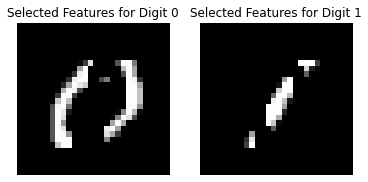

Accuracy on test set: 0.9995271867612293


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Select the top k features using Chi-Squared test
k = 200 # number of features you want to keep
chi2_selector = SelectKBest(chi2, k=k)
X_kbest = chi2_selector.fit_transform(X_scaled, y_train)
X_test_kbest = chi2_selector.transform(X_test_scaled) 
selected_features = chi2_selector.get_support(indices=True)
#print("Selected features:", selected_features)


# Training a logistic regression model
logistic_regression_model = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
logistic_regression_model.fit(X_kbest, y_train)

# Making predictions and evaluating the model
y_pred = logistic_regression_model.predict(X_test_kbest)
accuracy = accuracy_score(y_test, y_pred)
mask = np.isin(range(784), selected_features)  # 784 for MNIST 28x28 images

for i, digit in enumerate(np.unique(y_train)):
    # Find the first instance of the digit
    instance_index = np.where(y_train == digit)[0][0]
    image = X_train[instance_index].reshape(28, 28)

    # Apply the mask to the image to only show selected features
    masked_image = image * mask.reshape(28, 28)

    # Plot
    plt.subplot(1, len(np.unique(y_train)), i + 1)
    plt.imshow(masked_image, cmap='gray')
    plt.title(f"Selected Features for Digit {digit}")
    plt.axis('off')

plt.show()
print("Accuracy on test set:", accuracy)

c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\si

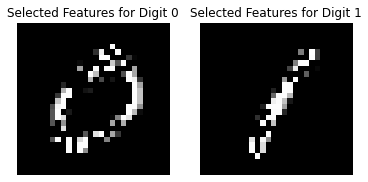

Accuracy on test set: 0.9995271867612293


In [ ]:
logistic_reg = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
# Create an RFE model and select 5 features
rfe_model = RFE(estimator=logistic_reg, n_features_to_select=200, step=10)
# Fit the RFE model on the dataset
rfe_model.fit(X_train, y_train)
y_pred = rfe_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# Get the indices of the selected features
selected_indices = np.where(rfe_model.support_)[0]

# Plot one example of each class (0 and 1)
for i, digit in enumerate(np.unique(y_train)):
    # Find the first instance of the digit
    instance_index = np.where(y_train == digit)[0][0]
    image = X_train[instance_index].reshape(28,28)

    # Mask the image to only show selected features
    mask = np.isin(range(X_train.shape[1]), selected_indices)
    masked_image = image * mask.reshape(28, 28)

    # Plot
    plt.subplot(1, 2, i + 1)
    plt.imshow(masked_image, cmap='gray')
    plt.title(f"Selected Features for Digit {digit}")
    plt.axis('off')

plt.show()
print("Accuracy on test set:", accuracy)

c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

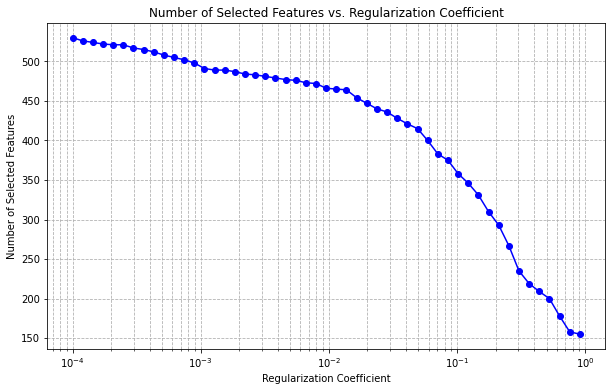

In [ ]:
reg_coeff_values=[]
select_features_list=[]
val_acc_list=[]
reg_coeff =0.0001
while reg_coeff<=1:  
    reg_coeff_values.append(reg_coeff)
    # Create a Logistic Regression model with L1 penalty (Lasso) 
    model = LogisticRegression(penalty='l1', C=1/reg_coeff, solver='saga',max_iter=200, random_state=42)
    model.fit(X_train, y_train)
    select_feature=np.sum(model.coef_!= 0)
    select_features_list.append(select_feature)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    val_acc_list.append(accuracy)
    reg_coeff*=1.2
reg_coeff_values_array = np.array(reg_coeff_values)
select_features_array = np.array(select_features_list)
select_features_list=np.array(select_features_list)
# Plotting Number of Selected Features vs. Regularization Coefficient
plt.figure(figsize=(10,6))
plt.plot(reg_coeff_values_array, select_features_array, '-o', color='blue')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Number of Selected Features')
plt.title('Number of Selected Features vs. Regularization Coefficient')
plt.xscale('log') # Since regularization coefficients can vary over orders of magnitude
# plt.yticks(range(1, 21))
plt.grid(True, which="both", ls="--")
plt.show()

c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


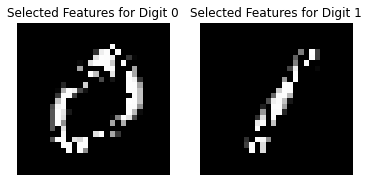

Number of selected features: 205
Accuracy on test set: 0.9995271867612293


In [ ]:
model = LogisticRegression(penalty='l1', C=1/0.5, solver='saga',max_iter=200, random_state=42)
model.fit(X_train, y_train)
num_select_feature=np.sum(model.coef_!= 0)
selected_indices = np.where(model.coef_ != 0)[1]
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
for i, digit in enumerate(np.unique(y_train)):
    # Find the first instance of the digit
    instance_index = np.where(y_train == digit)[0][0]
    image = X_train[instance_index].reshape(28,28)

    # Mask the image to only show selected features
    mask = np.isin(range(X_train.shape[1]), selected_indices)
    masked_image = image * mask.reshape(28, 28)

    # Plot
    plt.subplot(1, 2, i + 1)
    plt.imshow(masked_image, cmap='gray')
    plt.title(f"Selected Features for Digit {digit}")
    plt.axis('off')

plt.show()
print("Number of selected features:", num_select_feature)
print("Accuracy on test set:", accuracy)

In [119]:
# Set seed 
seed=42
cuda = False
use_cuda = cuda and torch.cuda.is_available()
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# Handel GPU stochasticity
torch.backends.cudnn.enabled = use_cuda
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if use_cuda else "cpu") 
lr=0.01
model = LogisticRegression(input_dim=X_train.shape[1], learning_rate=lr, batch_size=64, lam=0.01, device=device)
model.to(device)
epochs=2000

train_losses,val_losses,train_acc,val_acc,weights=model.fit(X_train, y_train, nr_epochs=epochs, valid_X=X_valid, valid_y=y_valid, print_interval=1000)


Epoch 1000: Train Loss: 0.1458, Val Loss: 0.1370
Epoch 2000: Train Loss: 0.1348, Val Loss: 0.1194


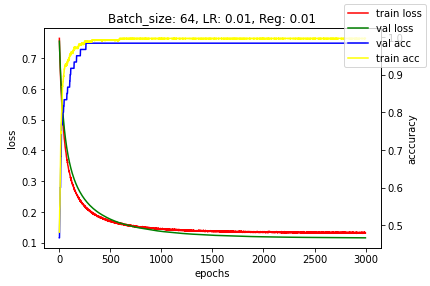

In [117]:
steps = np.arange(epochs)

fig, ax1 = plt.subplots()

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title(f'Batch_size: {model.batch_size}, LR: {lr}, Reg: {model.lam}')
ax1.plot(steps, train_losses, label="train loss", color='red')
ax1.plot(steps, val_losses, label="val loss", color='green')
ax2 = ax1.twinx()  
ax2.set_ylabel('acccuracy')  
ax2.plot(steps, val_acc, label="val acc", color='blue')
ax2.plot(steps, train_acc, label="train acc", color='yellow')

fig.legend()
fig.tight_layout()
plt.show()

# Testing the Model

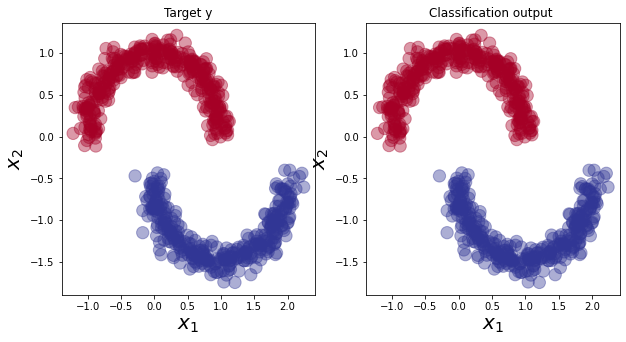

In [120]:
y_pred=model.predict(X_test)

f,ax = plt.subplots(1,2,figsize=(10,5))
  
ax[0].scatter(x=X_test[:,0], y=X_test[:,1], s=150, c=y_test.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_test[:,0], y=X_test[:,1], s=150, c=y_pred.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].set_xlabel('$x_1$',fontsize=20)
ax[1].set_ylabel('$x_2$',fontsize=20)
ax[1].set_title('Classification output ')
plt.tick_params(labelsize=10)

## Feature Selection Using Lasso 

This section demonstrates feature selection through Lasso Regression by visualizing the change in feature coefficients with different values of the Lasso Regularization coefficient. 





feature coefficients with Reg coeff = 0 : tensor([ 0.5318, -0.9692, -0.1329,  0.0644,  0.0833,  0.0600, -0.1711,  0.0112,
        -0.1213, -0.1321, -0.0614, -0.0522,  0.2872, -0.0922, -0.1408,  0.1166,
         0.0272,  0.0709, -0.1374,  0.0784])
feature coefficients with Reg coeff = 0.0005 : tensor([ 0.5625, -1.0417, -0.0453, -0.0037,  0.0946,  0.0263, -0.0508, -0.1356,
        -0.0948, -0.0465, -0.0490,  0.0690,  0.1357, -0.0113, -0.0960,  0.0358,
        -0.0862, -0.0257, -0.1146,  0.0416])
feature coefficients with Reg coeff = 0.001 : tensor([ 0.3756, -1.1975, -0.0808, -0.0374,  0.1041,  0.0187, -0.0528,  0.0075,
        -0.1561,  0.0306, -0.0781, -0.0019,  0.1545, -0.1176, -0.0719,  0.0069,
        -0.0211,  0.1020, -0.0560, -0.0391])
feature coefficients with Reg coeff = 0.01 : tensor([ 3.9167e-01, -1.1172e+00, -9.8330e-02,  3.8315e-04, -2.7452e-02,
         1.7010e-02, -2.9304e-02, -3.0341e-02, -4.5067e-04, -1.9576e-04,
        -4.9992e-02,  3.0449e-02,  2.5054e-01, -1.2583e-02,

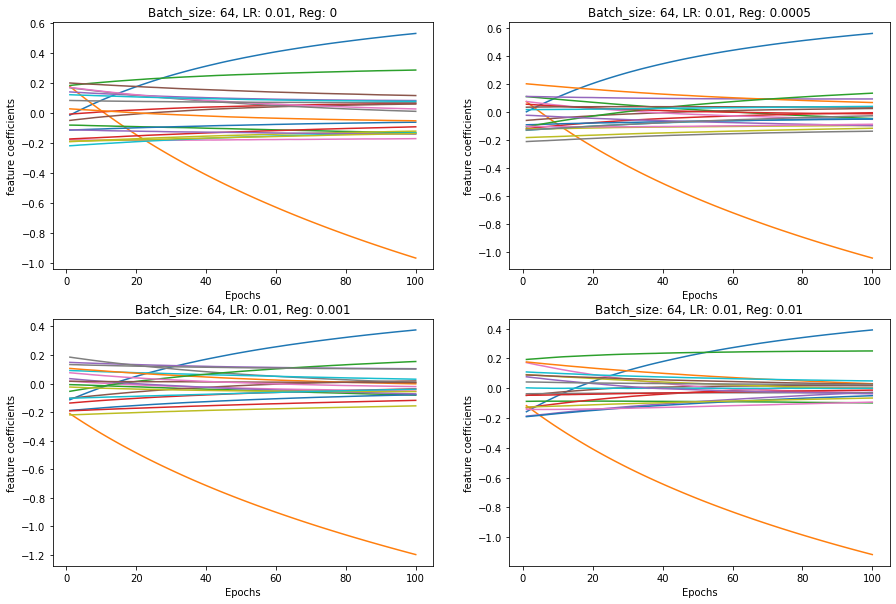

In [118]:
lambdas=[0, 0.0005, 0.001, 0.01]
epochs=100 
lr=0.01
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes=axes.flatten()  

for i, lam in enumerate(lambdas):
    weights=0
    model = LogisticRegression(input_dim=X_train.shape[1], learning_rate=lr, batch_size=64, lam=lam, device=device)
    model.to(device)
    train_losses,val_losses,train_acc,val_acc,weights=model.fit(X_train, y_train, nr_epochs=epochs, valid_X=X_valid, valid_y=y_valid, print_interval=200)
    weights = torch.stack(weights) 
    weights = weights.squeeze(1)
    print(f"feature coefficients with Reg coeff = {lam} : {weights[-1,:]}")
    features = weights.size(1) 
    for j in range(features):
        axes[i].plot(range(1, epochs + 1), weights[:, j].cpu().numpy())
    axes[i].set_title(f'Batch_size: {model.batch_size}, LR: {lr}, Reg: {lam}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('feature coefficients')

plt.show()
